In [ ]:
# ========== IMPORTS ==========
import os
import numpy as np
from tqdm import tqdm
from PIL import Image

# Keras
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inc_preprocess

# PyTorch
import torch
import torch.nn as nn
from torchvision import models, transforms

# Sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# ========== PATHS ==========
base_path = "/content/drive/MyDrive/graduation project/trial_split"
vgg_path = "/content/drive/MyDrive/graduation project/models/Vgg16.h5"
inc_path = "/content/drive/MyDrive/graduation project/models/OCT_InceptionV3.h5"
sqz_path = "/content/drive/MyDrive/graduation project/models/squeezNet.pth"
splits = ["train", "val", "test"]
classes = ['AMD', 'DME', 'ERM', 'NO']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# VGG16 (Keras)
vgg = load_model(vgg_path)
vgg_model = Model(inputs=vgg.input, outputs=vgg.layers[-3].output)

# InceptionV3 (Keras)
inc = load_model(inc_path)
inc_model = Model(inputs=inc.input, outputs=inc.layers[-3].output)

# SqueezeNet (PyTorch)
sqz = models.squeezenet1_0(pretrained=False)
sqz.classifier[1] = nn.Conv2d(512, len(classes), kernel_size=(1, 1))
sqz.load_state_dict(torch.load(sqz_path, map_location=device))
sqz.to(device)
sqz.eval()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [ ]:
def get_image_paths(split):
    img_paths, labels = [], []
    for label, cls in enumerate(classes):
        folder = os.path.join(base_path, split, cls)
        for f in os.listdir(folder):
            img_paths.append(os.path.join(folder, f))
            labels.append(label)
    return img_paths, labels


In [ ]:
def extract_vgg_features(img_paths):
    feats = []
    for path in tqdm(img_paths, desc="VGG16"):
        img = keras_image.load_img(path, target_size=(224, 224))
        x = keras_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = vgg_preprocess(x)
        feat = vgg_model.predict(x, verbose=0)
        feats.append(feat.flatten())
    return np.array(feats)

def extract_inc_features(img_paths):
    feats = []
    for path in tqdm(img_paths, desc="InceptionV3"):
        img = keras_image.load_img(path, target_size=(299, 299))
        x = keras_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_preprocess(x)
        feat = inc_model.predict(x, verbose=0)
        feats.append(feat.flatten())
    return np.array(feats)

def extract_sqz_features(img_paths):
    feats = []
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    with torch.no_grad():
        for path in tqdm(img_paths, desc="SqueezeNet"):
            try:
                img = Image.open(path).convert("RGB")
                x = transform(img).unsqueeze(0).to(device)
                feat = sqz.features(x).squeeze().cpu().numpy().flatten()
                feats.append(feat)
            except Exception as e:
                print(f"Error with {path}: {e}")
    return np.array(feats)


In [ ]:
def process_and_train():
    # -------- Train + Val --------
    train_paths, train_labels = get_image_paths("train")
    val_paths, val_labels = get_image_paths("val")

    all_train = train_paths + val_paths
    all_labels = train_labels + val_labels

    print("🔍 Extracting VGG16 features...")
    vgg_feats = extract_vgg_features(all_train)

    print("🔍 Extracting InceptionV3 features...")
    inc_feats = extract_inc_features(all_train)

    print("🔍 Extracting SqueezeNet features...")
    sqz_feats = extract_sqz_features(all_train)

    X_train = np.concatenate([vgg_feats, inc_feats, sqz_feats], axis=1)
    y_train = np.array(all_labels)

    # -------- Test --------
    test_paths, test_labels = get_image_paths("test")

    print("🔍 Extracting VGG16 test features...")
    vgg_test = extract_vgg_features(test_paths)

    print("🔍 Extracting InceptionV3 test features...")
    inc_test = extract_inc_features(test_paths)

    print("🔍 Extracting SqueezeNet test features...")
    sqz_test = extract_sqz_features(test_paths)

    X_test = np.concatenate([vgg_test, inc_test, sqz_test], axis=1)
    y_test = np.array(test_labels)

    # -------- Normalize + PCA --------
    print("⚙️ Normalizing + Applying PCA...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=300)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # -------- Train SVM --------
    print("🔧 Training SVM...")
    clf = SVC(kernel='rbf', C=10, probability=True)
    clf.fit(X_train_pca, y_train)

    # -------- Evaluate --------
    print("📊 Evaluating...")
    y_pred = clf.predict(X_test_pca)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=classes))
    print("Accuracy:", accuracy_score(y_test, y_pred))
def process_and_train():
    # -------- Train + Val --------
    train_paths, train_labels = get_image_paths("train")
    val_paths, val_labels = get_image_paths("val")

    all_train = train_paths + val_paths
    all_labels = train_labels + val_labels

    print("🔍 Extracting VGG16 features...")
    vgg_feats = extract_vgg_features(all_train)

    print("🔍 Extracting InceptionV3 features...")
    inc_feats = extract_inc_features(all_train)

    print("🔍 Extracting SqueezeNet features...")
    sqz_feats = extract_sqz_features(all_train)

    X_train = np.concatenate([vgg_feats, inc_feats, sqz_feats], axis=1)
    y_train = np.array(all_labels)

    # -------- Test --------
    test_paths, test_labels = get_image_paths("test")

    print("🔍 Extracting VGG16 test features...")
    vgg_test = extract_vgg_features(test_paths)

    print("🔍 Extracting InceptionV3 test features...")
    inc_test = extract_inc_features(test_paths)

    print("🔍 Extracting SqueezeNet test features...")
    sqz_test = extract_sqz_features(test_paths)

    X_test = np.concatenate([vgg_test, inc_test, sqz_test], axis=1)
    y_test = np.array(test_labels)

    # -------- Normalize + PCA --------
    print("⚙️ Normalizing + Applying PCA...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=300)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # -------- Train SVM --------
    print("🔧 Training SVM...")
    clf = SVC(kernel='rbf', C=10, probability=True)
    clf.fit(X_train_pca, y_train)

    # -------- Evaluate --------
    print("📊 Evaluating...")
    y_pred = clf.predict(X_test_pca)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=classes))
    print("Accuracy:", accuracy_score(y_test, y_pred))


In [ ]:
process_and_train()


🔍 Extracting VGG16 features...


VGG16: 100%|██████████| 4226/4226 [1:10:02<00:00,  1.01it/s]


🔍 Extracting InceptionV3 features...


InceptionV3: 100%|██████████| 4226/4226 [22:44<00:00,  3.10it/s]


🔍 Extracting SqueezeNet features...


SqueezeNet: 100%|██████████| 4226/4226 [03:27<00:00, 20.32it/s]


🔍 Extracting VGG16 test features...


VGG16: 100%|██████████| 749/749 [12:02<00:00,  1.04it/s]


🔍 Extracting InceptionV3 test features...


InceptionV3: 100%|██████████| 749/749 [04:03<00:00,  3.07it/s]


🔍 Extracting SqueezeNet test features...


SqueezeNet: 100%|██████████| 749/749 [00:36<00:00, 20.44it/s]


⚙️ Normalizing + Applying PCA...
🔧 Training SVM...
📊 Evaluating...

Classification Report:
              precision    recall  f1-score   support

         AMD       0.89      0.97      0.93       186
         DME       0.96      0.93      0.95       177
         ERM       0.99      0.92      0.96       186
          NO       0.97      0.97      0.97       200

    accuracy                           0.95       749
   macro avg       0.95      0.95      0.95       749
weighted avg       0.95      0.95      0.95       749

Accuracy: 0.9506008010680908


In [ ]:
# ✅ Feature-Level Fusion: VGG16 (Keras) + InceptionV3 (Keras) + SqueezeNet (PyTorch)

import os
import numpy as np
from tqdm import tqdm
from PIL import Image

# Keras imports
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inc_preprocess

# PyTorch imports
import torch
import torch.nn as nn
from torchvision import models, transforms

# Sklearn + XGBoost
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score

# ---------- Paths and Config ----------
base_path = "/content/drive/MyDrive/graduation project/trial_split"
classes = ['AMD', 'DME', 'ERM', 'NO']
vgg_path = "/content/drive/MyDrive/graduation project/models/Vgg16.h5"
inc_path = "/content/drive/MyDrive/graduation project/models/OCT_InceptionV3.h5"
sqz_path = "/content/drive/MyDrive/graduation project/models/squeezNet.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------- Load Models ----------
vgg = load_model(vgg_path)
print("\n📌 VGG16 Layers:")
for i, layer in enumerate(vgg.layers):
    print(f"{i}: {layer.name} - {layer.output.shape}")

inc = load_model(inc_path)
print("\n📌 InceptionV3 Layers:")
for i, layer in enumerate(inc.layers):
    print(f"{i}: {layer.name} - {layer.output.shape}")

sqz_model = models.squeezenet1_0(pretrained=False)
sqz_model.classifier[1] = nn.Conv2d(512, 4, kernel_size=(1, 1))
sqz_model.load_state_dict(torch.load(sqz_path, map_location=device))
sqz_model.to(device).eval()

print("\n📌 SqueezeNet (PyTorch) Layers:")
print(sqz_model)



📌 VGG16 Layers:
0: input_layer - (None, 224, 224, 3)
1: block1_conv1 - (None, 224, 224, 64)
2: block1_conv2 - (None, 224, 224, 64)
3: block1_pool - (None, 112, 112, 64)
4: block2_conv1 - (None, 112, 112, 128)
5: block2_conv2 - (None, 112, 112, 128)
6: block2_pool - (None, 56, 56, 128)
7: block3_conv1 - (None, 56, 56, 256)
8: block3_conv2 - (None, 56, 56, 256)
9: block3_conv3 - (None, 56, 56, 256)
10: block3_pool - (None, 28, 28, 256)
11: block4_conv1 - (None, 28, 28, 512)
12: block4_conv2 - (None, 28, 28, 512)
13: block4_conv3 - (None, 28, 28, 512)
14: block4_pool - (None, 14, 14, 512)
15: block5_conv1 - (None, 14, 14, 512)
16: block5_conv2 - (None, 14, 14, 512)
17: block5_conv3 - (None, 14, 14, 512)
18: block5_pool - (None, 7, 7, 512)
19: flatten - (None, 25088)
20: dense - (None, 512)
21: dropout - (None, 512)
22: dense_1 - (None, 4)



📌 InceptionV3 Layers:
0: input_1 - (None, 299, 299, 3)
1: conv2d - (None, 149, 149, 32)
2: batch_normalization - (None, 149, 149, 32)
3: activation - (None, 149, 149, 32)
4: conv2d_1 - (None, 147, 147, 32)
5: batch_normalization_1 - (None, 147, 147, 32)
6: activation_1 - (None, 147, 147, 32)
7: conv2d_2 - (None, 147, 147, 64)
8: batch_normalization_2 - (None, 147, 147, 64)
9: activation_2 - (None, 147, 147, 64)
10: max_pooling2d - (None, 73, 73, 64)
11: conv2d_3 - (None, 73, 73, 80)
12: batch_normalization_3 - (None, 73, 73, 80)
13: activation_3 - (None, 73, 73, 80)
14: conv2d_4 - (None, 71, 71, 192)
15: batch_normalization_4 - (None, 71, 71, 192)
16: activation_4 - (None, 71, 71, 192)
17: max_pooling2d_1 - (None, 35, 35, 192)
18: conv2d_8 - (None, 35, 35, 64)
19: batch_normalization_8 - (None, 35, 35, 64)
20: activation_8 - (None, 35, 35, 64)
21: conv2d_6 - (None, 35, 35, 48)
22: conv2d_9 - (None, 35, 35, 96)
23: batch_normalization_6 - (None, 35, 35, 48)
24: batch_normalization_9 - 

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# ✅ Feature-Level Fusion with Caching: VGG16 + InceptionV3 + SqueezeNet

import os
import numpy as np
from tqdm import tqdm
from PIL import Image

# Keras imports
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.preprocessing import image as keras_image
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inc_preprocess

# PyTorch imports
import torch
import torch.nn as nn
from torchvision import models, transforms

# Sklearn + XGBoost
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# ---------- Paths and Config ----------
base_path = "/content/drive/MyDrive/graduation project/trial_split"
cache_dir = "/content/drive/MyDrive/graduation project/features_cache"
classes = ['AMD', 'DME', 'ERM', 'NO']
vgg_path = "/content/drive/MyDrive/graduation project/models/Vgg16.h5"
inc_path = "/content/drive/MyDrive/graduation project/models/OCT_InceptionV3.h5"
sqz_path = "/content/drive/MyDrive/graduation project/models/squeezNet.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs(cache_dir, exist_ok=True)

# ---------- Load Models ----------
vgg = load_model(vgg_path)
vgg_model = Model(inputs=vgg.input, outputs=vgg.get_layer("flatten").output)

inc = load_model(inc_path)
inc_model = Model(inputs=inc.input, outputs=inc.get_layer("global_average_pooling2d").output)

sqz_model = models.squeezenet1_0(pretrained=False)
sqz_model.classifier[1] = nn.Conv2d(512, 4, kernel_size=(1, 1))
sqz_model.load_state_dict(torch.load(sqz_path, map_location=device))
sqz_model.to(device).eval()

# ---------- Image Utilities ----------
def get_image_paths(split):
    paths, labels = [], []
    for idx, cls in enumerate(classes):
        folder = os.path.join(base_path, split, cls)
        for fname in os.listdir(folder):
            paths.append(os.path.join(folder, fname))
            labels.append(idx)
    return paths, labels

# ---------- Feature Extractors with Caching ----------
def cache_path(model_name, split):
    return os.path.join(cache_dir, f"{model_name}_{split}.npy")

def extract_or_load_keras(model, img_paths, size, preprocess, model_name, split):
    path = cache_path(model_name, split)
    if os.path.exists(path):
        print(f"✅ Loaded {model_name}-{split} features from cache")
        return np.load(path)
    feats = []
    for img_path in tqdm(img_paths, desc=f"{model_name}-{split}"):
        img = keras_image.load_img(img_path, target_size=(size, size))
        x = keras_image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess(x)
        f = model.predict(x, verbose=0)
        feats.append(f.flatten())
    feats = np.array(feats)
    np.save(path, feats)
    return feats

def extract_or_load_squeezenet(img_paths, split):
    path = cache_path("SqueezeNet", split)
    if os.path.exists(path):
        print(f"✅ Loaded SqueezeNet-{split} features from cache")
        return np.load(path)
    feats = []
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    with torch.no_grad():
        for path_img in tqdm(img_paths, desc=f"SqueezeNet-{split}"):
            img = Image.open(path_img).convert("RGB")
            x = transform(img).unsqueeze(0).to(device)
            f = sqz_model.features(x).view(-1).cpu().numpy()
            feats.append(f)
    feats = np.array(feats)
    np.save(path, feats)
    return feats

# ---------- Classifier Comparison ----------
def evaluate_models(X_train, y_train, X_test, y_test):
    models = {
        "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=5,
                                 use_label_encoder=False, eval_metric='mlogloss'),
        "RandomForest": RandomForestClassifier(n_estimators=200),
        "SVM": SVC(kernel='rbf', probability=True),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "MLPClassifier": MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300)
    }

    for name, model in models.items():
        print(f"\n🔍 Training {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"📊 {name} Accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred, target_names=classes))

# ---------- Main Pipeline ----------
def run_pipeline():
    train_paths, train_labels = get_image_paths("train")
    val_paths, val_labels = get_image_paths("val")
    test_paths, test_labels = get_image_paths("test")

    all_train_paths = train_paths + val_paths
    all_train_labels = train_labels + val_labels

    vgg_feats = extract_or_load_keras(vgg_model, all_train_paths, 224, vgg_preprocess, "VGG16", "train")
    inc_feats = extract_or_load_keras(inc_model, all_train_paths, 299, inc_preprocess, "InceptionV3", "train")
    sqz_feats = extract_or_load_squeezenet(all_train_paths, "train")

    X_train = np.concatenate([0.4*vgg_feats, 0.4*inc_feats, 0.2*sqz_feats], axis=1)
    y_train = np.array(all_train_labels)

    vgg_test = extract_or_load_keras(vgg_model, test_paths, 224, vgg_preprocess, "VGG16", "test")
    inc_test = extract_or_load_keras(inc_model, test_paths, 299, inc_preprocess, "InceptionV3", "test")
    sqz_test = extract_or_load_squeezenet(test_paths, "test")

    X_test = np.concatenate([0.4*vgg_test, 0.4*inc_test, 0.2*sqz_test], axis=1)
    y_test = np.array(test_labels)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=300)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    evaluate_models(X_train_pca, y_train, X_test_pca, y_test)

# ---------- Run ----------
run_pipeline()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
SqueezeNet-test: 100%|██████████| 749/749 [00:38<00:00, 19.34it/s]



🔍 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:16:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 XGBoost Accuracy: 0.9546
              precision    recall  f1-score   support

         AMD       0.96      0.94      0.95       186
         DME       0.96      0.95      0.95       177
         ERM       0.95      0.94      0.95       186
          NO       0.95      0.99      0.97       200

    accuracy                           0.95       749
   macro avg       0.95      0.95      0.95       749
weighted avg       0.95      0.95      0.95       749


🔍 Training RandomForest...
📊 RandomForest Accuracy: 0.9372
              precision    recall  f1-score   support

         AMD       0.91      0.94      0.92       186
         DME       0.95      0.92      0.93       177
         ERM       0.96      0.91      0.94       186
          NO       0.93      0.97      0.95       200

    accuracy                           0.94       749
   macro avg       0.94      0.94      0.94       749
weighted avg       0.94      0.94      0.94       749


🔍 Training SVM...
📊 SVM Accuracy: 0.9506
 

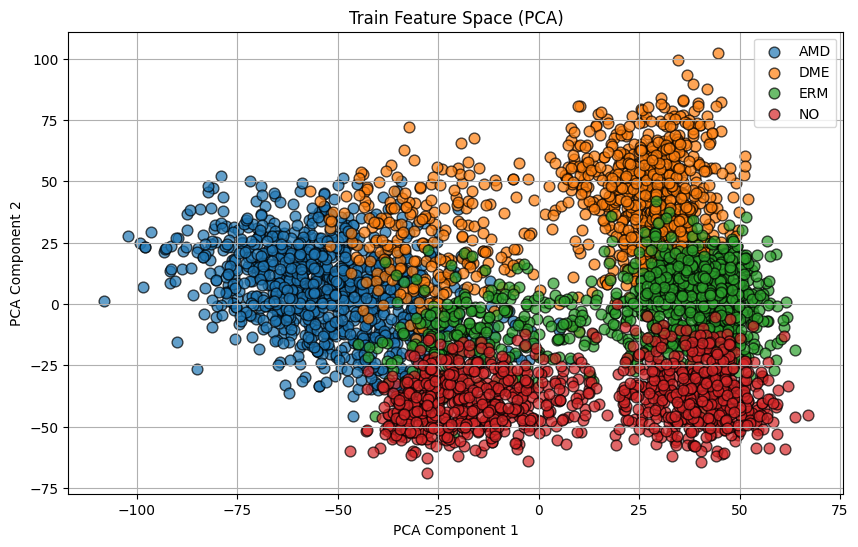

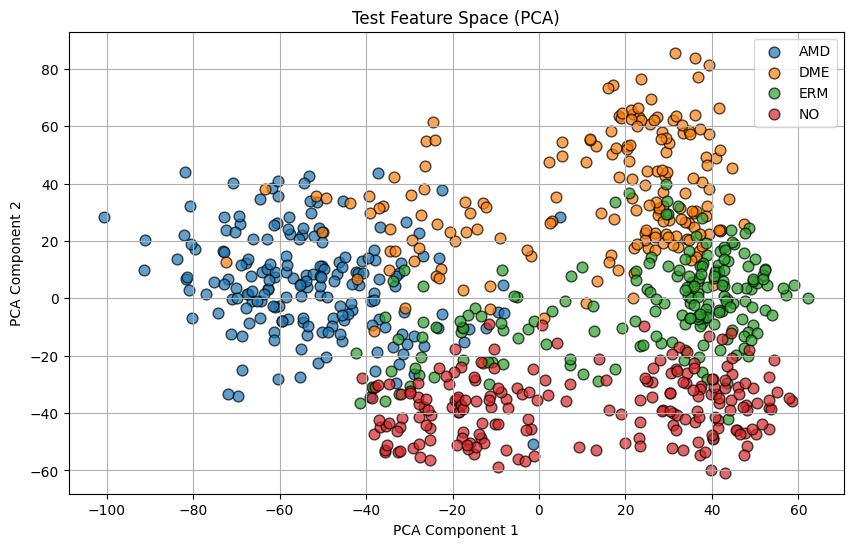

In [1]:
# 🔧 Imports and Setup
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# 📁 Paths
base_path = "/content/drive/MyDrive/graduation project/trial_split"
cache_dir = "/content/drive/MyDrive/graduation project/features_cache"
results_path = "/content/drive/MyDrive/graduation project/best_model_result.json"
classes = ['AMD', 'DME', 'ERM', 'NO']
os.makedirs(cache_dir, exist_ok=True)

# 📌 Utilities
def get_image_paths(split):
    paths, labels = [], []
    for idx, cls in enumerate(classes):
        folder = os.path.join(base_path, split, cls)
        for fname in os.listdir(folder):
            paths.append(os.path.join(folder, fname))
            labels.append(idx)
    return paths, labels

def plot_pca_features(X, y, classes, title="PCA Feature Space", misclassified_mask=None):
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette('Set2', len(classes))
    for idx, cls in enumerate(classes):
        mask = (np.array(y) == idx)
        plt.scatter(X[mask, 0], X[mask, 1], label=cls, alpha=0.7, s=60, edgecolor='k')
    if misclassified_mask is not None:
        plt.scatter(X[misclassified_mask, 0], X[misclassified_mask, 1], c='red', marker='x', label='Misclassified')
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

def plot_decision_boundary(model, X, y, title="Decision Boundary"):
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.8)
    for idx, cls in enumerate(classes):
        mask = (np.array(y) == idx)
        plt.scatter(X[mask, 0], X[mask, 1], label=cls, edgecolor='k', s=50)
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.grid(True)
    plt.show()

def load_features(split):
    vgg = np.load(f"{cache_dir}/VGG16_{split}.npy")
    inc = np.load(f"{cache_dir}/InceptionV3_{split}.npy")
    sqz = np.load(f"{cache_dir}/SqueezeNet_{split}.npy")
    return np.concatenate([0.4 * vgg, 0.4 * inc, 0.2 * sqz], axis=1)

# ✅ Load and preprocess data
train_paths, train_labels = get_image_paths("train")
val_paths, val_labels = get_image_paths("val")
test_paths, test_labels = get_image_paths("test")

y_train = np.array(train_labels + val_labels)
y_test = np.array(test_labels)

X_train = load_features("train")
X_test = load_features("test")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plot_pca_features(X_train_pca, y_train, classes, title="Train Feature Space (PCA)")
plot_pca_features(X_test_pca, y_test, classes, title="Test Feature Space (PCA)")

best_model_name = None
best_acc = 0.0



📊 RandomForest Accuracy: 0.9599
              precision    recall  f1-score   support

         AMD       0.96      0.97      0.96       186
         DME       0.94      0.95      0.94       177
         ERM       0.96      0.94      0.95       186
          NO       0.98      0.98      0.98       200

    accuracy                           0.96       749
   macro avg       0.96      0.96      0.96       749
weighted avg       0.96      0.96      0.96       749



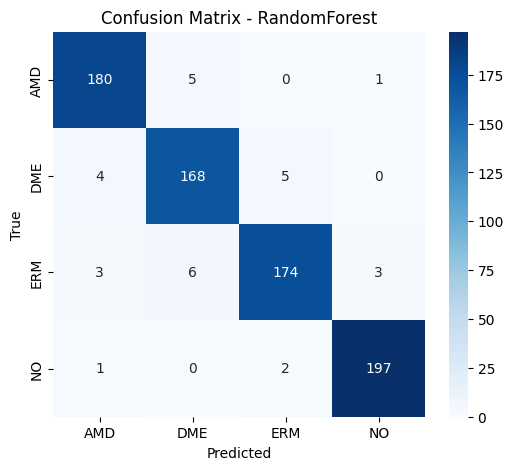

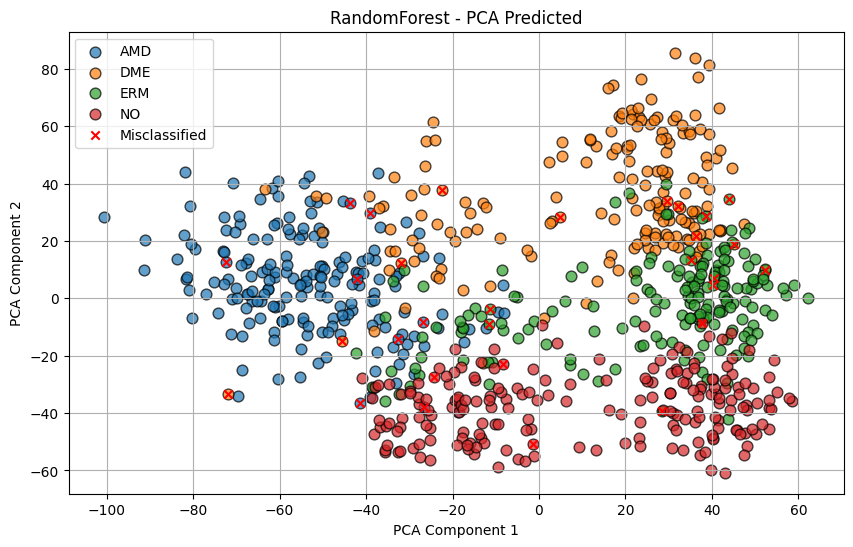

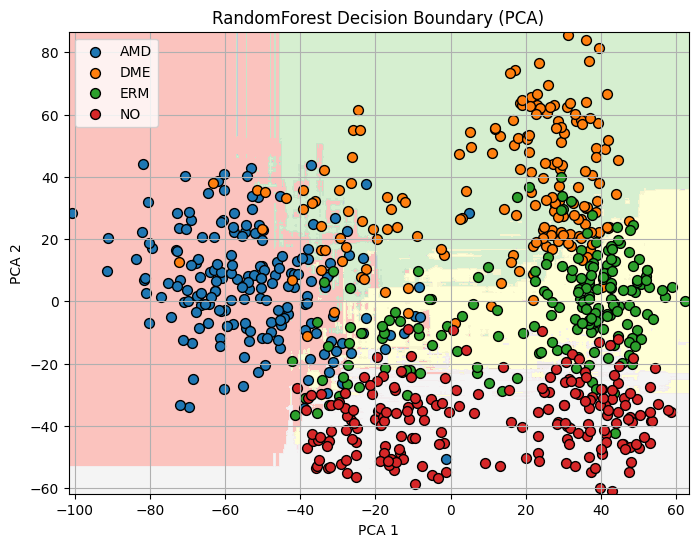

In [3]:
# ✅ Model: RandomForestClassifier (trained on full feature space)
model = RandomForestClassifier(n_estimators=200)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# 📈 Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"\n📊 RandomForest Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=classes))
misclassified_mask = (y_pred != y_test)

# 📊 Visualizations
plot_confusion_matrix(y_test, y_pred, classes, model_name="RandomForest")
plot_pca_features(X_test_pca, y_pred, classes, title="RandomForest - PCA Predicted", misclassified_mask=misclassified_mask)

# ⚠️ PCA decision boundary requires training on PCA-transformed data
model_pca = RandomForestClassifier(n_estimators=200)
model_pca.fit(X_train_pca, y_train)
plot_decision_boundary(model_pca, X_test_pca, y_test, title="RandomForest Decision Boundary (PCA)")

# 🏆 Update best model if applicable
if acc > best_acc:
    best_acc = acc
    best_model_name = "RandomForest"



📊 ExtraTrees Accuracy: 0.9640
              precision    recall  f1-score   support

         AMD       0.96      0.97      0.97       186
         DME       0.94      0.96      0.95       177
         ERM       0.97      0.94      0.96       186
          NO       0.98      0.98      0.98       200

    accuracy                           0.96       749
   macro avg       0.96      0.96      0.96       749
weighted avg       0.96      0.96      0.96       749



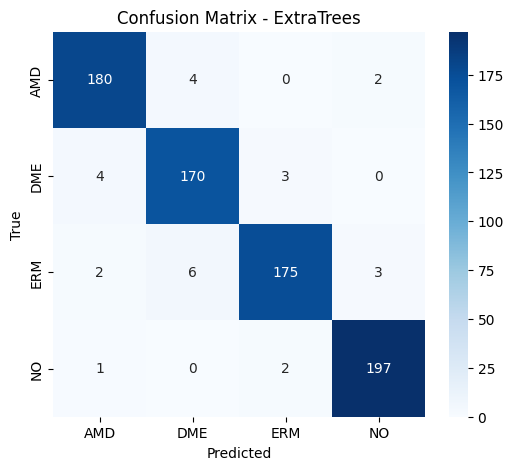

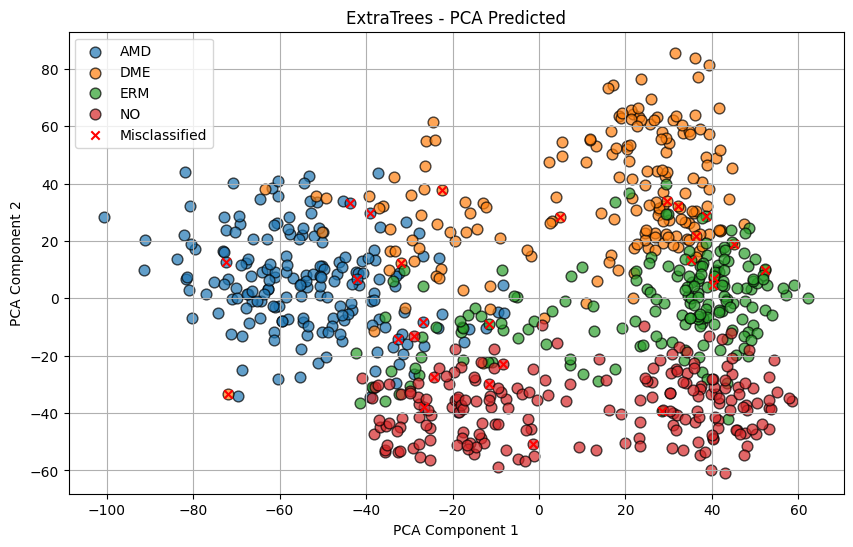

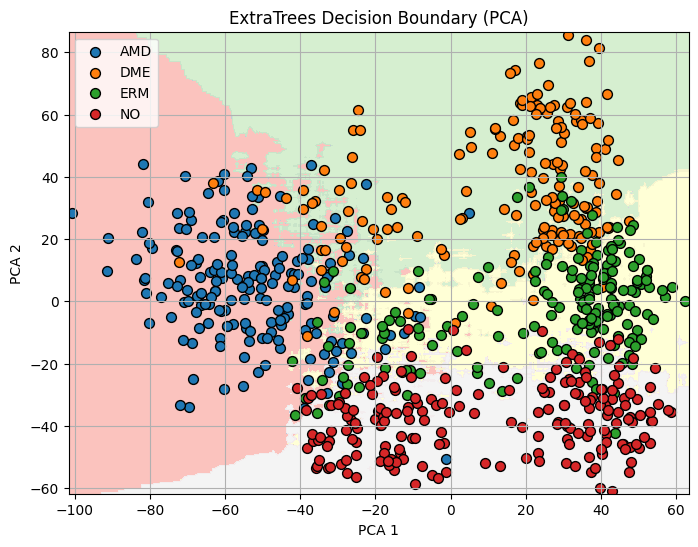

In [2]:
# ✅ Model: ExtraTreesClassifier (trained on full feature space)
model = ExtraTreesClassifier(n_estimators=200)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# 📈 Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"\n📊 ExtraTrees Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=classes))
misclassified_mask = (y_pred != y_test)

# 📊 Visualizations
plot_confusion_matrix(y_test, y_pred, classes, model_name="ExtraTrees")
plot_pca_features(X_test_pca, y_pred, classes, title="ExtraTrees - PCA Predicted", misclassified_mask=misclassified_mask)

# ⚠️ Train on PCA-transformed data for decision boundary
model_pca = ExtraTreesClassifier(n_estimators=200)
model_pca.fit(X_train_pca, y_train)
plot_decision_boundary(model_pca, X_test_pca, y_test, title="ExtraTrees Decision Boundary (PCA)")

# 🏆 Update best model if applicable
if acc > best_acc:
    best_acc = acc
    best_model_name = "ExtraTrees"


In [3]:
# ✅ Model: AdaBoostClassifier (trained on full feature space)
model = AdaBoostClassifier(n_estimators=200)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# 📈 Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"\n📊 AdaBoost Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=classes))
misclassified_mask = (y_pred != y_test)

# 📊 Visualizations
plot_confusion_matrix(y_test, y_pred, classes, model_name="AdaBoost")
plot_pca_features(X_test_pca, y_pred, classes, title="AdaBoost - PCA Predicted", misclassified_mask=misclassified_mask)

# 🏆 Update best model if applicable
if acc > best_acc:
    best_acc = acc
    best_model_name = "AdaBoost"


KeyboardInterrupt: 

In [ ]:
# ✅ Model: SVM (Support Vector Machine, trained on full feature space)
model = SVC(kernel='rbf', probability=True)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# 📈 Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"\n📊 SVM Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=classes))
misclassified_mask = (y_pred != y_test)

# 📊 Visualizations
plot_confusion_matrix(y_test, y_pred, classes, model_name="SVM")
plot_pca_features(X_test_pca, y_pred, classes, title="SVM - PCA Predicted", misclassified_mask=misclassified_mask)

# 🏆 Update best model if applicable
if acc > best_acc:
    best_acc = acc
    best_model_name = "SVM"



📊 KNN Accuracy: 0.7356
              precision    recall  f1-score   support

         AMD       0.89      0.26      0.41       186
         DME       0.93      0.85      0.88       177
         ERM       0.87      0.83      0.85       186
          NO       0.56      0.99      0.71       200

    accuracy                           0.74       749
   macro avg       0.81      0.73      0.71       749
weighted avg       0.81      0.74      0.71       749



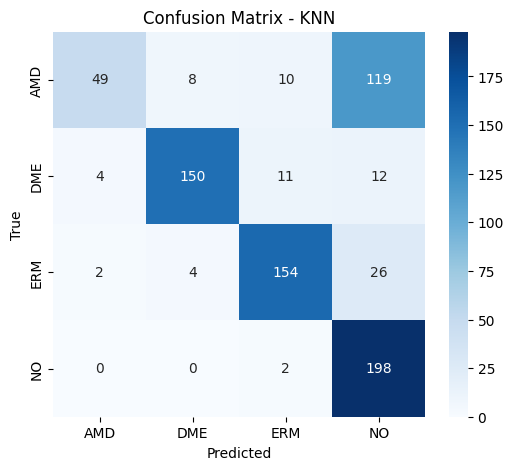

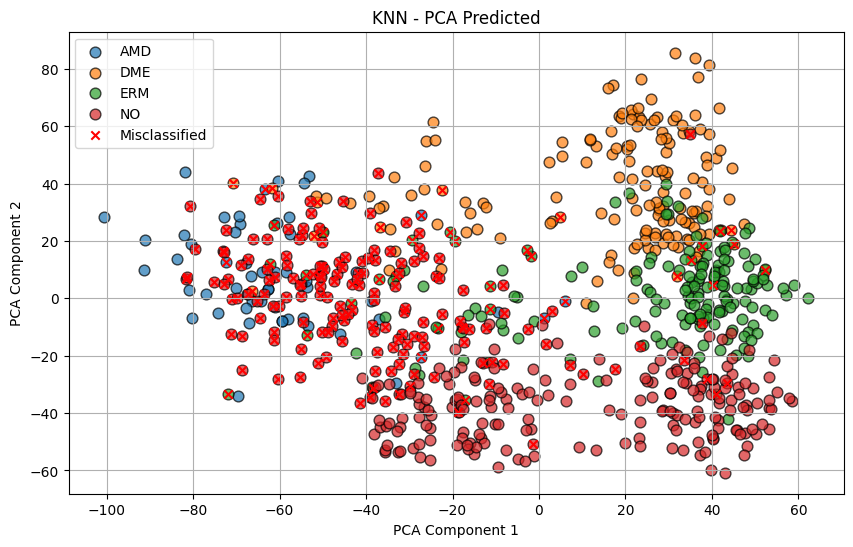

In [2]:
# ✅ Model: KNeighborsClassifier (trained on full feature space)
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# 📈 Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"\n📊 KNN Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=classes))
misclassified_mask = (y_pred != y_test)

# 📊 Visualizations
plot_confusion_matrix(y_test, y_pred, classes, model_name="KNN")
plot_pca_features(X_test_pca, y_pred, classes, title="KNN - PCA Predicted", misclassified_mask=misclassified_mask)

# 🏆 Update best model if applicable
if acc > best_acc:
    best_acc = acc
    best_model_name = "KNN"



📊 LogisticRegression Accuracy: 0.9653
              precision    recall  f1-score   support

         AMD       0.96      0.96      0.96       186
         DME       0.97      0.96      0.96       177
         ERM       0.98      0.94      0.96       186
          NO       0.96      0.99      0.98       200

    accuracy                           0.97       749
   macro avg       0.97      0.96      0.96       749
weighted avg       0.97      0.97      0.97       749



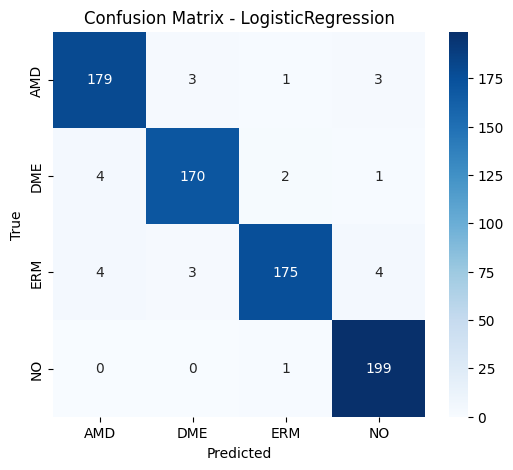

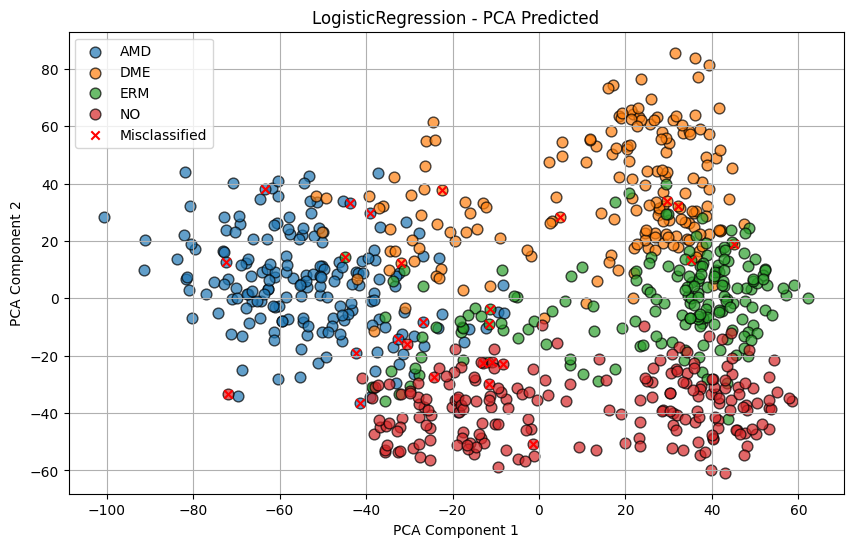

In [2]:
# ✅ Model: LogisticRegression (trained on full feature space)
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# 📈 Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"\n📊 LogisticRegression Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=classes))
misclassified_mask = (y_pred != y_test)

# 📊 Visualizations
plot_confusion_matrix(y_test, y_pred, classes, model_name="LogisticRegression")
plot_pca_features(X_test_pca, y_pred, classes, title="LogisticRegression - PCA Predicted", misclassified_mask=misclassified_mask)

# 🏆 Update best model if applicable
if acc > best_acc:
    best_acc = acc
    best_model_name = "LogisticRegression"


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:252: LinAlgWarning: Ill-conditioned matrix (rcond=7.66951e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)



📊 RidgeClassifier Accuracy: 0.9573
              precision    recall  f1-score   support

         AMD       0.95      0.94      0.95       186
         DME       0.97      0.97      0.97       177
         ERM       0.96      0.94      0.95       186
          NO       0.96      0.97      0.97       200

    accuracy                           0.96       749
   macro avg       0.96      0.96      0.96       749
weighted avg       0.96      0.96      0.96       749



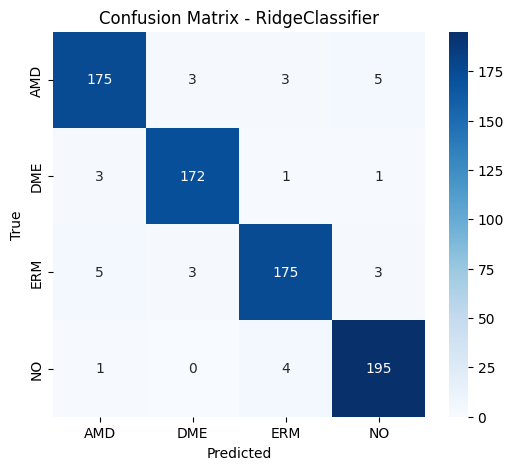

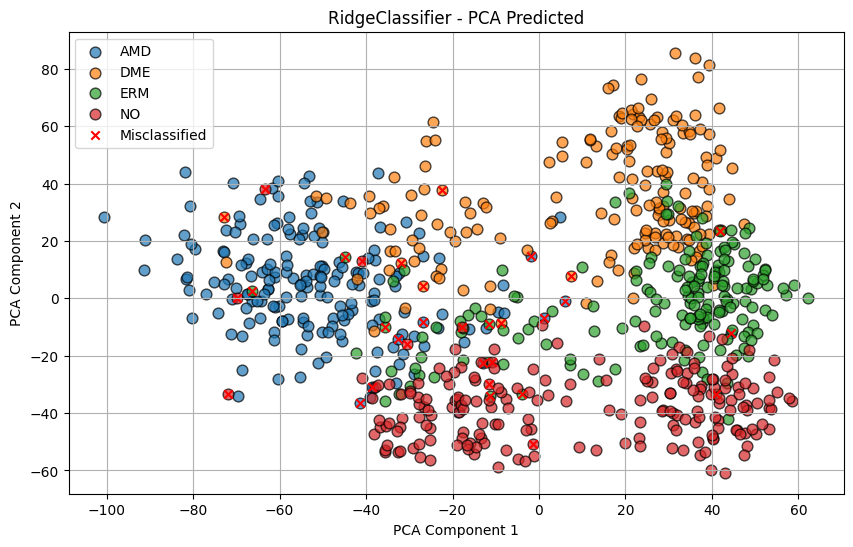

In [4]:
# ✅ Model: RidgeClassifier (trained on full feature space)
model = RidgeClassifier()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# 📈 Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"\n📊 RidgeClassifier Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=classes))
misclassified_mask = (y_pred != y_test)

# 📊 Visualizations
plot_confusion_matrix(y_test, y_pred, classes, model_name="RidgeClassifier")
plot_pca_features(X_test_pca, y_pred, classes, title="RidgeClassifier - PCA Predicted", misclassified_mask=misclassified_mask)

# 🏆 Update best model if applicable
if acc > best_acc:
    best_acc = acc
    best_model_name = "RidgeClassifier"




📊 SGDClassifier Accuracy: 0.9466
              precision    recall  f1-score   support

         AMD       0.95      0.93      0.94       186
         DME       0.94      0.97      0.96       177
         ERM       0.96      0.91      0.93       186
          NO       0.94      0.97      0.96       200

    accuracy                           0.95       749
   macro avg       0.95      0.95      0.95       749
weighted avg       0.95      0.95      0.95       749



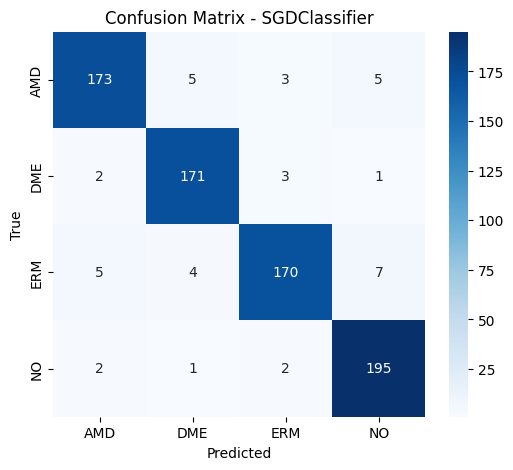

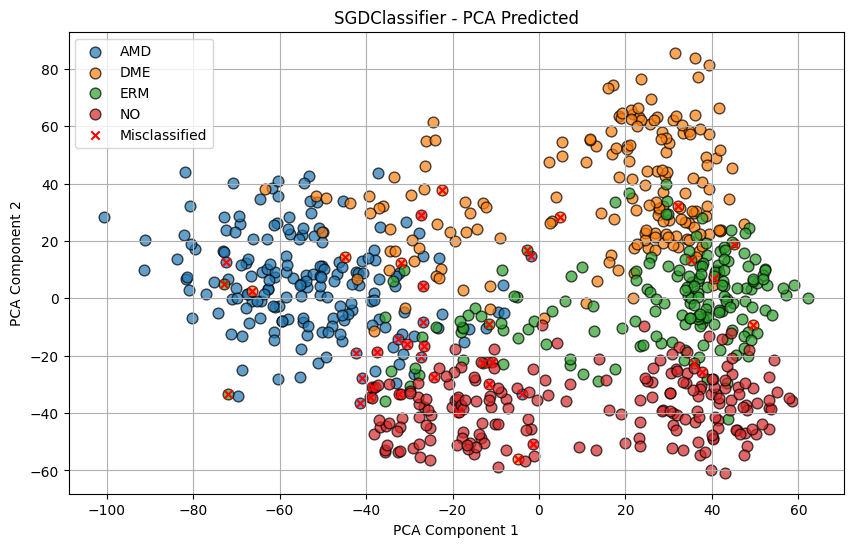

In [5]:
# ✅ Model: SGDClassifier (trained on full feature space)
model = SGDClassifier(max_iter=1000, tol=1e-3)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# 📈 Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"\n📊 SGDClassifier Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=classes))
misclassified_mask = (y_pred != y_test)

# 📊 Visualizations
plot_confusion_matrix(y_test, y_pred, classes, model_name="SGDClassifier")
plot_pca_features(X_test_pca, y_pred, classes, title="SGDClassifier - PCA Predicted", misclassified_mask=misclassified_mask)

# 🏆 Update best model if applicable
if acc > best_acc:
    best_acc = acc
    best_model_name = "SGDClassifier"



📊 NaiveBayes Accuracy: 0.6822
              precision    recall  f1-score   support

         AMD       0.57      0.74      0.65       186
         DME       0.73      0.64      0.68       177
         ERM       0.75      0.68      0.71       186
          NO       0.72      0.67      0.69       200

    accuracy                           0.68       749
   macro avg       0.69      0.68      0.68       749
weighted avg       0.69      0.68      0.68       749



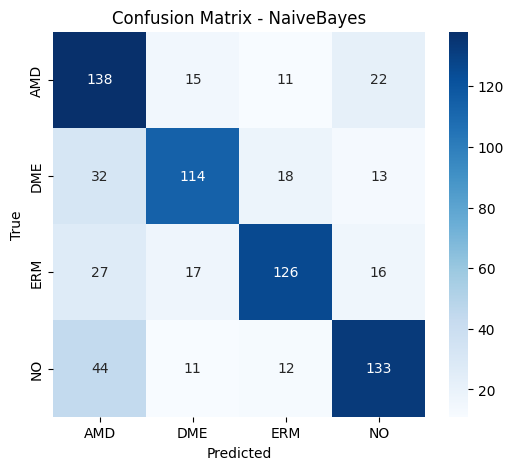

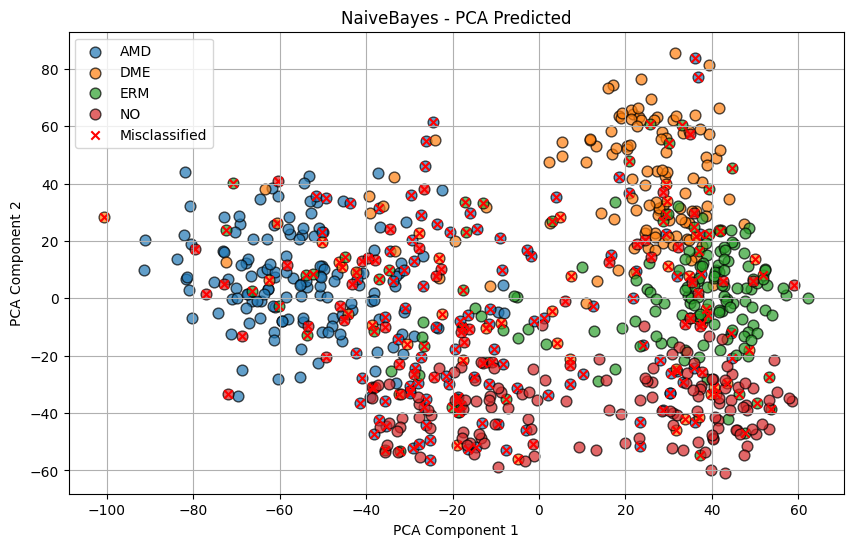

In [6]:
# ✅ Model: GaussianNB (trained on full feature space)
model = GaussianNB()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# 📈 Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"\n📊 NaiveBayes Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=classes))
misclassified_mask = (y_pred != y_test)

# 📊 Visualizations
plot_confusion_matrix(y_test, y_pred, classes, model_name="NaiveBayes")
plot_pca_features(X_test_pca, y_pred, classes, title="NaiveBayes - PCA Predicted", misclassified_mask=misclassified_mask)

# 🏆 Update best model if applicable
if acc > best_acc:
    best_acc = acc
    best_model_name = "NaiveBayes"


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")



📊 MLPClassifier Accuracy: 0.9479
              precision    recall  f1-score   support

         AMD       0.94      0.94      0.94       186
         DME       0.98      0.95      0.96       177
         ERM       0.98      0.91      0.94       186
          NO       0.91      0.99      0.95       200

    accuracy                           0.95       749
   macro avg       0.95      0.95      0.95       749
weighted avg       0.95      0.95      0.95       749



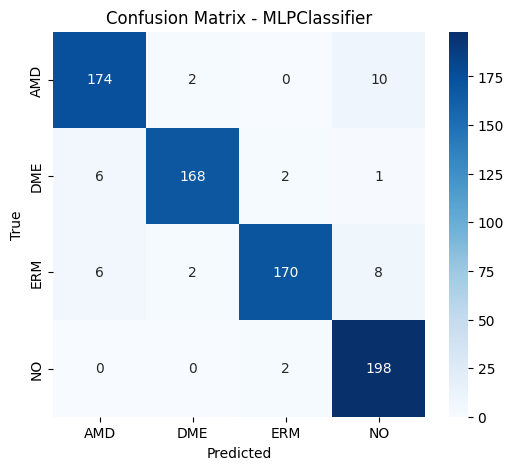

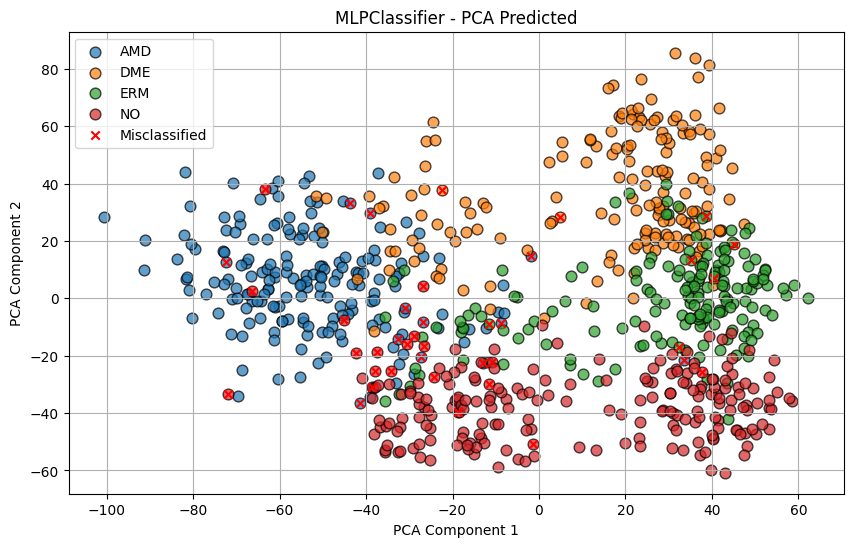

In [2]:
# ✅ Model: MLPClassifier (trained on full feature space)
model = MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=300)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# 📈 Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"\n📊 MLPClassifier Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=classes))
misclassified_mask = (y_pred != y_test)

# 📊 Visualizations
plot_confusion_matrix(y_test, y_pred, classes, model_name="MLPClassifier")
plot_pca_features(X_test_pca, y_pred, classes, title="MLPClassifier - PCA Predicted", misclassified_mask=misclassified_mask)

# 🏆 Update best model if applicable
if acc > best_acc:
    best_acc = acc
    best_model_name = "MLPClassifier"


In [2]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=100,        # أقل عدد أشجار
    learning_rate=0.05,      # Learning rate أبطأ
    max_depth=3,             # تقليل العمق لتقليل التعقيد
    subsample=0.7,           # تقليل العينات المستخدمة بكل شجرة
    colsample_bytree=0.7,    # تقليل عدد الخصائص المستخدمة
    gamma=0.2,               # عقوبة على الانقسامات الضعيفة
    reg_alpha=0.2,           # L1 regularization أقوى
    reg_lambda=1.5,          # L2 regularization أقوى
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=1
)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# 📈 Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"\n📊 XGBoost (Light) Accuracy: {acc:.4f}")
print(classification_report(y_test, y_pred, target_names=classes))
misclassified_mask = (y_pred != y_test)

# 📊 Visualizations
plot_confusion_matrix(y_test, y_pred, classes, model_name="XGBoost (Light)")
plot_pca_features(X_test_pca, y_pred, classes, title="XGBoost (Light) - PCA Predicted", misclassified_mask=misclassified_mask)

# 🏆 Update best model if applicable
if acc > best_acc:
    best_acc = acc
    best_model_name = "XGBoost (Light)"


NameError: name 'X_train_scaled' is not defined